In [40]:
##  ____________ _____ _   _  _____  ___  ______________ _   _ _      _____  
## |  _  \ ___ \  _  | \ | ||  ___| |  \/  |  _  |  _  \ | | | |    |  ___| 
## | | | | |_/ / | | |  \| || |__   | .  . | | | | | | | | | | |    | |__   
## | | | |    /| | | | . ` ||  __|  | |\/| | | | | | | | | | | |    |  __|  
## | |/ /| |\ \\ \_/ / |\  || |___  | |  | \ \_/ / |/ /| |_| | |____| |___  
## |___/ \_| \_|\___/\_| \_/\____/  \_|  |_/\___/|___/  \___/\_____/\____/  
##  _____ _____ _____ _____  ____________  ___   _   _ _____  _   _         
## |_   _|  ___/  ___|_   _| | ___ \ ___ \/ _ \ | \ | /  __ \| | | |        
##   | | | |__ \ `--.  | |   | |_/ / |_/ / /_\ \|  \| | /  \/| |_| |        
##   | | |  __| `--. \ | |   | ___ \    /|  _  || . ` | |    |  _  |        
##   | | | |___/\__/ / | |   | |_/ / |\ \| | | || |\  | \__/\| | | |        
##   \_/ \____/\____/  \_/   \____/\_| \_\_| |_/\_| \_/\____/\_| |_/        
                                                                         
#######################################################
##                        Notes                      ##
#######################################################

## 20210706 -- WT
## This is the test branch for the drone module I'm trying to create for the Newburgh Lab drone analysis pipeline
## This will hopefully become a python module that can be easily used by the group with a lot of copy-pasta-ing
## I will comment as heavily as possible, and pull code from several previously used analysis scripts:
    ##     191014_OVRO_Flight_Processing.ipynb
    ##     20210409_LFOP_SpecAn_and_VNA_Work.ipynb
    ##     20210414_LFOP_Hacking.ipynb
    ##     BMX_Beam_Map.ipynb
    ##     Drone_Class_from_processed_CSV.ipynb
    ##     OVRO_Timestamp_Sync_Tests.ipynb
    ##     OVRO_data_vis.ipynb
    
## 20210801 -- WT
## ADDITIONAL VECTORIZATION CODING/PROOFS ##
    # CHANGES to drone class following this work:
    # 1. Want to initialize with additional receiver/array variables in dimensioned arrays:
            ##############################################################################################
            # I  Variable      # Dimension # description
            ##############################################################################################
            # A. Keys          # n dishes  # (string with name or channel index?)
            # B. Coordinates   # n by 3vec # (Vector position in local cartesian (E,N,U) relative origin)
            # C. Pointings     # n by 3vec # (Unit Vector in local cartesian (E,N,U))
            # D. Polarizations # n by 3vec # (Unit Vector in local cartesian (E,N,U))
            ##############################################################################################
    # 2. Want to calculate drone coordinates on per-dish basis, for xyz and rpt from origin based arrays

#######################################################
##                  Module Contents                  ##
#######################################################

## Import packages used in analysis script:
import numpy as np
from matplotlib.pyplot import *
import glob
import os
import datetime
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from random import sample
from astropy.time import Time
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import pytz
import bisect
import pygeodesy
from mpl_toolkits import mplot3d
import pandas

## Define directories that contain modules/files of interest:
working_directory=u"/Users/wct9/python/"
bmxdata_directory=u'/Users/wct9/python/bmxdaq/py/'
drone_mod_directory=u'/Users/wct9/python/dronehacks/'
BMX_directory=u'/Users/wct9/python/yale_bmx/BMX_Data/'
drone_directory=u'/Users/wct9/python/yale_bmx/Drone_Data/'

## Import bmxdata package to use BMXFile: BMXFile(*_yale_D1.data)
os.chdir(bmxdata_directory)
from bmxdata import BMXFile
os.chdir(working_directory)

## Specify relevant coordinates in llh:
VECT_Drone_Start_LOC=pygeodesy.ellipsoidalNvector.LatLon(40.87031876496191, -72.86561763277804, 23.964228339399998).to3llh()
VECT_BMX_E_LOC=pygeodesy.ellipsoidalNvector.LatLon(40.86995317295864, -72.86603925418495, 19.464228339399998).to3llh()

## DEFN the Gauss Fit function:
def Gauss(x,a,x0,sigma,k):
    return a*np.exp(-(x-x0)**2.0/(2.0*sigma**2.0))+k

## Rotation Matrix for Yaw,Pitch,Roll rotations about z,y,x axes:
def RotMat(ypr_arr):
    [a,b,c]=(np.pi/180.0)*ypr_arr
    RM=np.ndarray((3,3))
    RM[0,:]=[np.cos(a)*np.cos(b),np.cos(a)*np.sin(b)*np.sin(c)-np.sin(a)*np.cos(c),np.cos(a)*np.sin(b)*np.cos(c)+np.sin(a)*np.sin(c)]
    RM[1,:]=[np.sin(a)*np.cos(b),np.sin(a)*np.sin(b)*np.sin(c)+np.cos(a)*np.cos(c),np.sin(a)*np.sin(b)*np.cos(c)-np.cos(a)*np.sin(c)]
    RM[2,:]=[-1*np.sin(b),np.cos(b)*np.sin(c),np.cos(b)*np.cos(c)]
    return RM

## Convert from cartesian to polar (r,phi,theta):
def xyz_to_rpt(xyz):
    r_prime=np.sqrt(xyz[0]**2.0+xyz[1]**2.0+xyz[2]**2.0)
    phi_prime=np.arctan2(xyz[1],xyz[0])
    if phi_prime<0:
        phi_prime=phi_prime+(2.0*np.pi)
    theta_prime=np.arccos(xyz[2]/r_prime)
    rpt=[r_prime,phi_prime,theta_prime]
    return rpt

## Make the colors cute and shit:
colorsarr=cm.gnuplot2(np.linspace(0,1,11))

class Drone_Data:
    def __init__(self,dronedir,FLYTAG,Origin_llh,dkeys,dcoords,dpointings,dpols):
        print('DRONE CLASS initialized -- Loading Drone RTK Data from '+FLYTAG.split('_Drone_')[0]+':')
        self.fn=FLYTAG
        self.Origin_llh=Origin_llh
        self.prime_origin=pygeodesy.EcefCartesian(latlonh0=Origin_llh[0],lon0=Origin_llh[1],height0=Origin_llh[2],name='BMX_Tower_Center')
        ## Define/declare array variables in class:
        self.dish_keystrings=dkeys
        self.dish_coords_LC=dcoords
        self.dish_pointings_LC=dpointings
        self.dish_pols_LC=dpols
        ## Read Drone RTK Data
        drone_data=pandas.read_csv(dronedir+FLYTAG)
        ## Assign Drone RTK Data to class variables:
        self.latitude=np.array(drone_data.Lat)
        self.longitude=np.array(drone_data.Lon)
        self.pitch=np.array(drone_data.pitch)
        self.roll=np.array(drone_data.roll)
        self.yaw=np.array(drone_data.yaw)
        self.velocity=np.array(drone_data.vel)
        self.hmsl=np.array(drone_data.hmsl)
        try:
            self.t_arr_timestamp=np.array(drone_data.timestamp)
        except AttributeError:
            self.t_arr_timestamp=np.array(drone_data.datetimestamp)
        self.t_index=np.arange(len(self.t_arr_timestamp))
        ## Construct useful secondary class variables
        self.altitude=np.array(drone_data.hmsl)[:]-Origin_llh[2]
        self.t_arr_datetime=np.array([np.datetime64(self.t_arr_timestamp[m]).astype(datetime.datetime).replace(tzinfo=pytz.UTC) for m in range(self.t_index.shape[0])])
        ## Define coordinate systems we will eventually want to use:
        print("generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.")
        self.coords_llh=np.ndarray((self.t_index.shape[0],3))     ## Lat,Lon,hmsl from drone/RTK
        self.coords_xyz_GC=np.ndarray((self.t_index.shape[0],3))  ## x,y,z in meters in geocentric cartesian
        self.coords_xyz_LC=np.ndarray((self.t_index.shape[0],3))  ## x,y,z cartesian wrt a chosen origin (x=E,y=N,z=up)
        self.coords_rpt=np.ndarray((self.t_index.shape[0],3))     ## r,theta,phi wrt a chosen origin
        ## Populate and calculate these coordinate systems:
        for i in self.t_index:
            ## Create LatLon point for each recorded drone position:
            p_t=pygeodesy.ellipsoidalNvector.LatLon(self.latitude[i],lon=self.longitude[i],height=self.hmsl[i])
            ## Assign llh, xyz, xyz_prime, rpt_prime coordinates, pointwise:
            self.coords_llh[i]=p_t.to3llh()
            self.coords_xyz_GC[i]=p_t.to3xyz()
            self.coords_xyz_LC[i]=self.prime_origin.forward(p_t).toVector()        
            r_prime=np.sqrt(self.coords_xyz_LC[i,0]**2.0+self.coords_xyz_LC[i,1]**2.0+self.coords_xyz_LC[i,2]**2.0)      
            phi_prime=np.arctan2(self.coords_xyz_LC[i,1],self.coords_xyz_LC[i,0])
            if phi_prime<0:
                phi_prime=phi_prime+(2.0*np.pi)
            theta_prime=np.arccos(self.coords_xyz_LC[i,2]/r_prime)
            self.coords_rpt[i]=[r_prime,phi_prime,theta_prime]
        print("generating dish and receiver line of sight coordinates.")
        ## Calculate per-dish polar coordinates for drone/receiver in each other's beams as fxn of time:
        self.rpt_r_per_dish=np.zeros((len(self.dish_keystrings),len(self.t_index),3)) # drone posn wrt receiver
        self.rpt_t_per_dish=np.zeros((len(self.dish_keystrings),len(self.t_index),3)) # receiver posn wrt drone
        for i in range(len(self.dish_keystrings)):
            ## Receiver RPT after TRANS and ROT: (from receiver N to Drone in Receiver Cartesian "RC" coords)
            drone_xyz_RC=self.coords_xyz_LC-self.dish_coords_LC[i] # translate LC to receiver i position
            ## Rotate coord system by dish pointing with rotation matrix (constant in t):
            rec_pointing_rot=RotMat(np.array([xyz_to_rpt(self.dish_pointings_LC[i])[2],0.0,xyz_to_rpt(self.dish_pointings_LC[i])[1]]))
            ## Populate receiver position wrt drone:
            self.rpt_r_per_dish[i,:,:]=np.array([xyz_to_rpt(rec_pointing_rot@drone_xyz_RC[k]) for k in range(len(self.coords_xyz_LC))])
            ## Transmitter RPT after TRANS and ROT: (from Drone to receiver N in Drone coords)
            rec_xyz_LC=-1.0*(self.coords_xyz_LC)+self.dish_coords_LC[i] # in LC relative to drone, without rotation (yet)
            ## Rotate coord system by drone pointing with rotation matrix (varies with yaw,pitch,roll as fxns of t):
            ypr=np.ndarray((len(self.t_index),3))
            ypr[:,0]=self.yaw
            ypr[:,1]=self.pitch
            ypr[:,2]=self.roll
            self.rpt_t_per_dish[i,:,:]=np.array([xyz_to_rpt(RotMat(ypr[m,:])@(RotMat(np.array([90.0,0.0,180.0]))@rec_xyz_LC[m])) for m in range(len(self.coords_xyz_LC))])
            
    def Plot_Drone_Coordinates(self,t_cut=False,t_bounds=[0,-1]):
        print('plotting drone coordinates for all time samples:')
        fig1,[[ax1,ax2,ax3],[ax4,ax5,ax6]]=subplots(nrows=2,ncols=3,figsize=(15,9))
        ## Plot p0 coordinate origin:
        ax1.plot(self.Origin_llh[0],self.Origin_llh[1],'ro')
        ax2.axhline(self.Origin_llh[0],c='b')
        ax3.axhline(self.Origin_llh[1],c='b')
        ## Title each coordinate subplot:        
        ax1.set_title('Lat vs Lon')
        ax2.set_title('Lat vs Time')
        ax3.set_title('Lon vs Time')
        ax4.set_title('Velocity vs Time')
        ax5.set_title('Altitude vs Time')
        ax6.set_title('Yaw vs Time')
        ## Specify arrays/vectors to plot in 1,3,4 coordinate subplot
        xqtys=[self.latitude,self.t_index,self.t_index,self.t_index,self.t_index,self.t_index]
        yqtys=[self.longitude,self.latitude,self.longitude,self.velocity,self.altitude,self.yaw]
        xtags=['Latitude, [$deg$]','Drone Index','Drone Index','Drone Index','Drone Index','Drone Index']
        ytags=['Longitude, [$deg$]','Latitude, [$deg$]','Longitude, [$deg$]','Velocity, [m/s]','Altitude, [$m$]','Yaw [$deg$]']
        if t_cut==False:
            for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
                ax.plot(xqtys[i],yqtys[i],'.',label='all samples')
                ax.set_xlabel(xtags[i])
                ax.set_ylabel(ytags[i])
                ax.grid()
                ax.legend()
        if t_cut==True:
            print('overplotting drone coordinates for t_cut samples: ['+str(t_bounds[0])+':'+str(t_bounds[1])+']')
            for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
                ax.plot(np.nanmin(xqtys[i][t_bounds[0]:t_bounds[1]]),np.nanmin(yqtys[i][t_bounds[0]:t_bounds[1]]))
                ax.plot(np.nanmax(xqtys[i][t_bounds[0]:t_bounds[1]]),np.nanmax(yqtys[i][t_bounds[0]:t_bounds[1]]))
                autoscalelims=ax.axis()
                ax.clear()
                ax.plot(xqtys[i],yqtys[i],'.',label='all samples')
                ax.plot(xqtys[i][t_bounds[0]:t_bounds[1]],yqtys[i][t_bounds[0]:t_bounds[1]],'.',label='selected samples')
                ax.set_xlabel(xtags[i])
                ax.set_ylabel(ytags[i])
                ax.grid()
                ax.legend()
                ax.set_xlim(autoscalelims[0],autoscalelims[1])
                ax.set_ylim(autoscalelims[2],autoscalelims[3])
        tight_layout()
        
    def Plot_Angular_Coordinates(self,t_bounds=[0,-1]):
        fig=figure(figsize=(15,4.5))
        ax1=fig.add_subplot(1, 3, 1)
        ax1.plot(self.t_index[:],(180/np.pi)*self.coords_rpt[:,1],'.')
        ax1.plot(self.t_index[t_bounds[0]:t_bounds[1]],(180/np.pi)*self.coords_rpt[t_bounds[0]:t_bounds[1],1],'.')
        ax1.set_xlabel('time index')
        ax1.set_ylabel(r'$\phi, [deg]$')
        ax2=fig.add_subplot(1, 3, 2)
        ax2.plot(self.t_index[:],(180/np.pi)*self.coords_rpt[:,2],'.')
        ax2.plot(self.t_index[t_bounds[0]:t_bounds[1]],(180/np.pi)*self.coords_rpt[t_bounds[0]:t_bounds[1],2],'.')
        ax2.set_xlabel('time index')
        ax2.set_ylabel(r'$\theta, [deg]$')
        ax3=fig.add_subplot(1, 3, 3, projection='polar')
        ax3.plot(self.coords_rpt[:,1],180/np.pi*self.coords_rpt[:,2],'.')
        ax3.plot(self.coords_rpt[t_bounds[0]:t_bounds[1],1],180/np.pi*self.coords_rpt[t_bounds[0]:t_bounds[1],2],'.')
        ax3.set_rlim(np.nanmin(180/np.pi*self.coords_rpt[t_bounds[0]:t_bounds[1],2]),1.1*np.nanmax(180/np.pi*self.coords_rpt[t_bounds[0]:t_bounds[1],2]))
        tight_layout()

    def Plot_3d(self,t_bounds=[0,-1]):
        fig=figure(figsize=(10,4.5))
        tkeys=['Geocentric Cartesian','Local Cartesian']
        for i,coordset in enumerate([self.coords_xyz_GC,self.coords_xyz_LC]):
            ax=fig.add_subplot(1, 2, i+1, projection='3d')
            ax.set_title(tkeys[i])
            ax.set_xlabel('x, [meters]')
            ax.set_ylabel('y, [meters]')
            ax.set_zlabel('z, [meters]')
            ax.plot(coordset[:,0],coordset[:,1],coordset[:,2],'.')
            ax.plot(coordset[t_bounds[0]:t_bounds[1],0],coordset[t_bounds[0]:t_bounds[1],1],coordset[t_bounds[0]:t_bounds[1],2],'.')
        tight_layout()
     
    def Plot_Transmitter_Pointing(self,t_bounds=[0,-1],t_step=10):
        fig=figure(figsize=(10,8))
        ax=fig.add_subplot(111)
        ## DRONE COORDINATE SYSTEM x,y,z=North,East,Down VARIABLES ##
        UV_nose_north=np.array([1,0,0]) #unit vector for nose pointing north, no roll/pitch, prior to rotations
        UV_trans_down=np.array([0,0,1]) #unit vector for transmitter pointing down prior to rotations
        ## drone roll, pitch, yaw angles:
        ypr=np.ndarray((len(self.t_index),3))
        ypr[:,0]=self.yaw
        ypr[:,1]=self.pitch
        ypr[:,2]=self.roll
        ## TRANSMITTER POINTING DIRECTION as fxn of time in Local Cartesian: (transform by [y,p,r]=[+90,0,+180] rot)
        trans_pointing_xyz=np.array([RotMat(np.array([90.0,0.0,180.0]))@RotMat(ypr[m,:])@UV_trans_down for m in range(len(self.t_index))])
        ## Plot Parameters:
        [Qlb,Qub,Qstep]=[t_bounds[0],t_bounds[1],t_step]
        M=np.abs(np.hypot(trans_pointing_xyz[Qlb:Qub:Qstep,0],trans_pointing_xyz[Qlb:Qub:Qstep,1]))
        CNorm=colors.Normalize()
        CNorm.autoscale(M)
        CM=cm.gnuplot2
        SM=cm.ScalarMappable(cmap=CM, norm=CNorm)
        SM.set_array([])
        q=ax.quiver(self.coords_xyz_LC[Qlb:Qub:Qstep,0],self.coords_xyz_LC[Qlb:Qub:Qstep,1],trans_pointing_xyz[Qlb:Qub:Qstep,0],trans_pointing_xyz[Qlb:Qub:Qstep,1],color=CM(CNorm(M)))
        ax.quiverkey(q,X=0.15,Y=0.05,U=1,label='Unit Vector', labelpos='E')
        fig.colorbar(SM,label='XY Projection Magnitude')
        ax.set_xlabel('Local X Position, [m]')
        ax.set_ylabel('Local Y Position, [m]')
        ax.set_title('Transmitter Deviation from Nadir [XY Projection]')
        tight_layout()

    def Plot_Polar_Lines_of_Sight(self,t_bounds=[0,-1],t_step=1):        
        fig1,axes=subplots(nrows=2,ncols=len(self.dish_keystrings),figsize=(4*len(self.dish_keystrings),8),subplot_kw=dict(projection="polar"))
        for i,ax in enumerate(axes[0]):
            ax.set_title(self.dish_keystrings[i])
            ax.plot(self.rpt_t_per_dish[i,t_bounds[0]:t_bounds[1]:t_step,1],180.0/np.pi*self.rpt_t_per_dish[i,t_bounds[0]:t_bounds[1]:t_step,2],'.b',markersize=0.5,label='Receiver Position in Drone Beam')
            ax.plot(0,0,'ro')
        ax.legend(loc=3)
        for j,ax in enumerate(axes[1]):
            ax.set_title(self.dish_keystrings[j])
            ax.plot(self.rpt_r_per_dish[j,t_bounds[0]:t_bounds[1]:t_step,1],180.0/np.pi*self.rpt_r_per_dish[j,t_bounds[0]:t_bounds[1]:t_step,2],'.g',markersize=0.5,label='Drone Position in Receiver Beam')
            ax.plot(0,0,'ro')
        ax.legend(loc=3)
        tight_layout()

In [2]:
## ADDITIONAL VECTORIZATION CODING/PROOFS ##
    # CHANGES to drone class following this work:
    # 1. Want to initialize with additional receiver/array variables in dimensioned arrays:
            ##############################################################################################
            # I  Variable      # Dimension # description
            ##############################################################################################
            # A. Keys          # n dishes  # (string with name or channel index?)
            # B. Coordinates   # n by 3vec # (Vector position in local cartesian (E,N,U) relative origin)
            # C. Pointings     # n by 3vec # (Unit Vector in local cartesian (E,N,U))
            # D. Polarizations # n by 3vec # (Unit Vector in local cartesian (E,N,U))
            ##############################################################################################
    # 2. Want to calculate drone coordinates on per-dish basis, for xyz and rpt from origin based arrays
    
## RECEIVER INFORMATION is needed to initialize the geometric environments: ##
## Must include some 'key' strings for labelling/identifying receivers:
Array_Keys=['North','East','South','West']
## Must Specify Coordinates and Pointings of receivers in Local Cartesian in an array of shape: n_receivers x 3 ##
Array_Coords=np.array([[-2.0,2.0,0.1],\
                       [0.0,0.0,0.1],\
                       [-2.0,-2.0,0.1],\
                       [-4.0,0.0,0.1]])
## If pointings are defined by vectors in Local Coordinates (E,N,U) use:
Array_Pointings=np.array([[0,0,1], # +Z (up) in LC \
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1]])
## If pointings are defined by angles from zenith, use:
Array_Pointings=np.array([RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),  # e.g. 1 deg of yaw and roll \
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0])])
## Define Array Polarizations (2 per dish) in Local Cartesian E,N,U:
Array_Pols=np.array([[[1,0,0],[0,1,0]], # E,N \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]]])

In [41]:
data=Drone_Data(dronedir=drone_directory,FLYTAG='FLY331_processed.csv',Origin_llh=VECT_BMX_E_LOC,dkeys=Array_Keys,dcoords=Array_Coords,dpointings=Array_Pointings,dpols=Array_Pols)

DRONE CLASS initialized -- Loading Drone RTK Data from FLY331_processed.csv:
generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
generating dish and receiver line of sight coordinates.


plotting drone coordinates for all time samples:
plotting drone coordinates for all time samples:
overplotting drone coordinates for t_cut samples: [17000:115000]


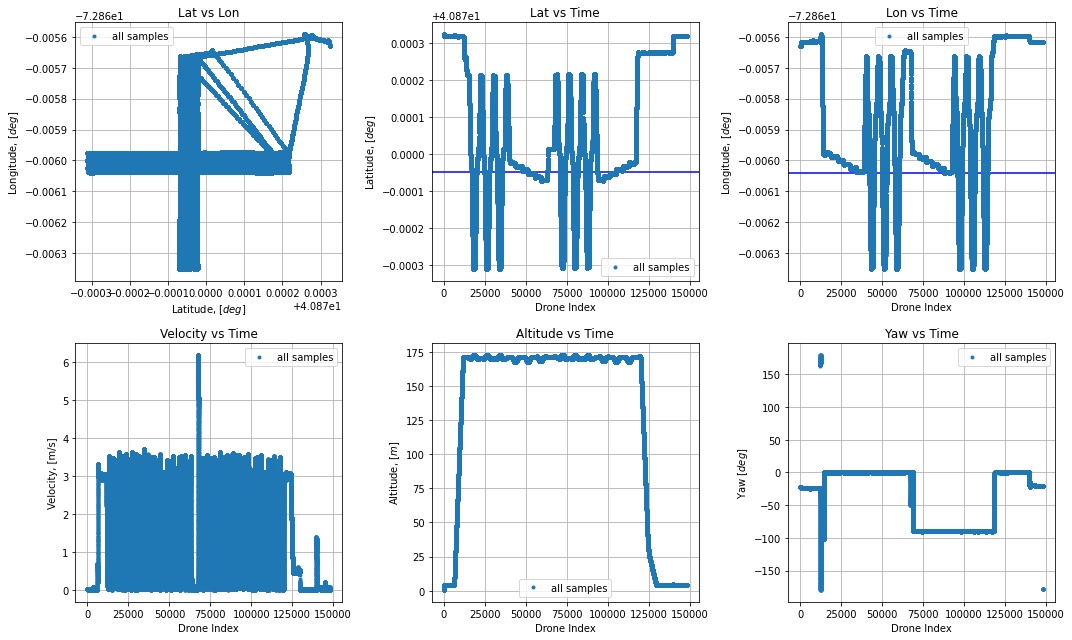

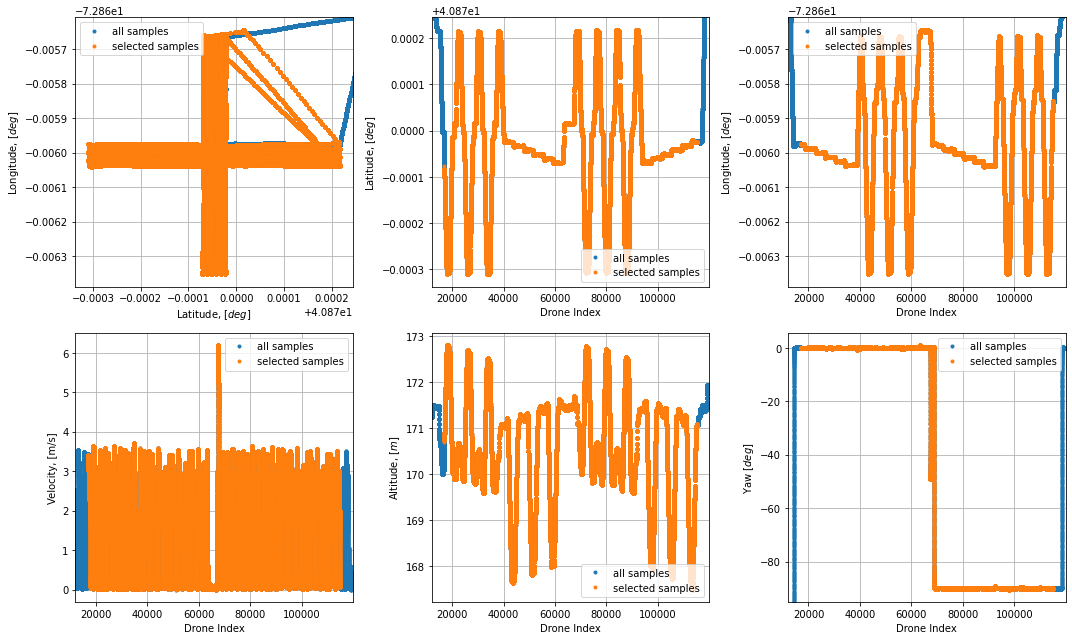

In [4]:
data.Plot_Drone_Coordinates()
data.Plot_Drone_Coordinates(t_cut=True,t_bounds=[17000,115000])

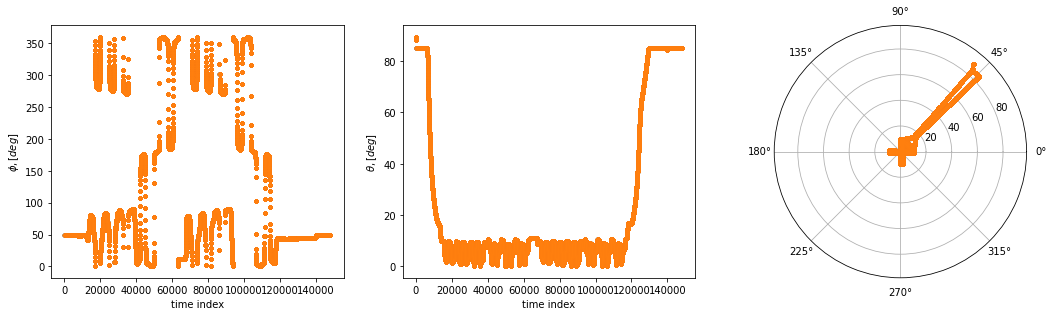

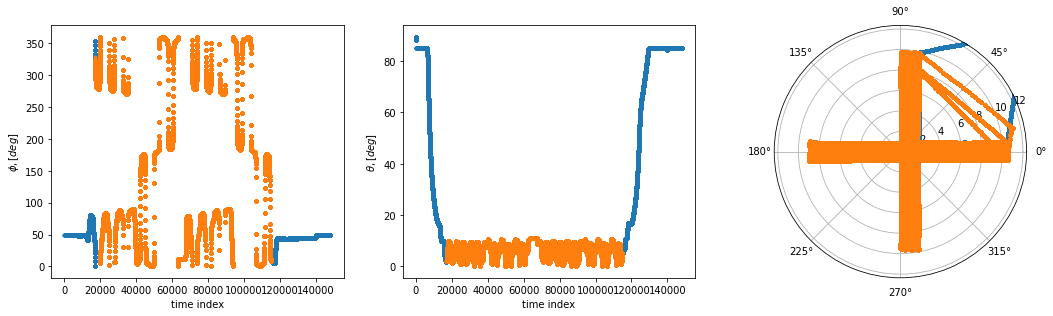

In [5]:
data.Plot_Angular_Coordinates()
data.Plot_Angular_Coordinates(t_bounds=[17000,115000])

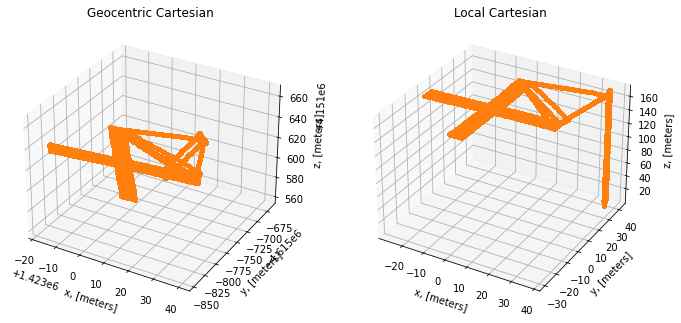

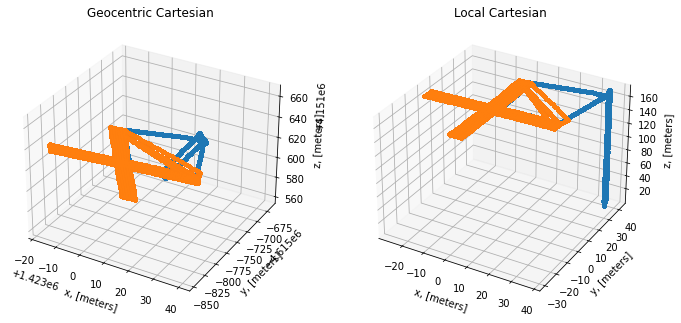

In [6]:
data.Plot_3d()
data.Plot_3d(t_bounds=[17000,115000])

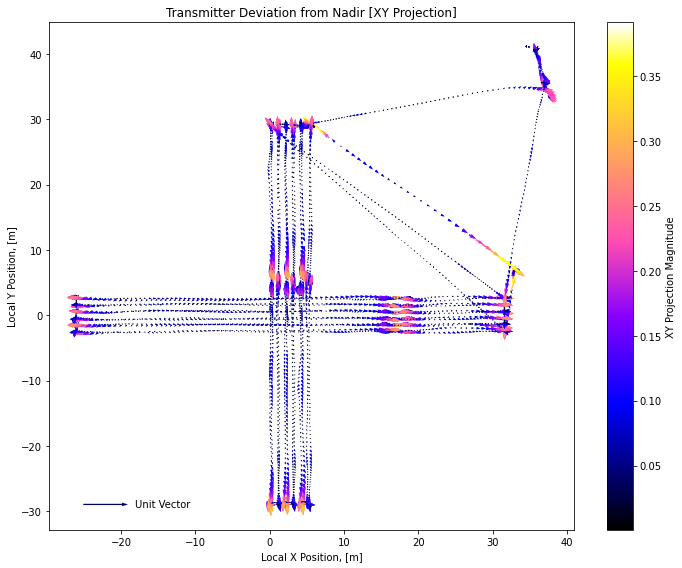

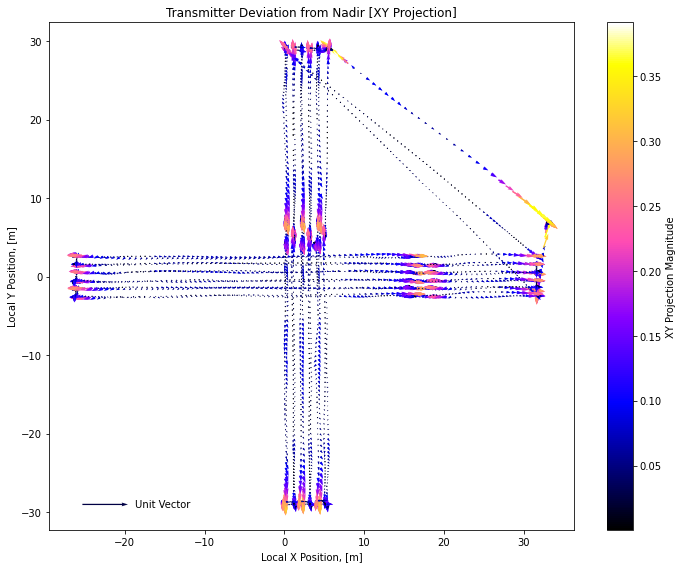

In [7]:
data.Plot_Transmitter_Pointing()
data.Plot_Transmitter_Pointing(t_bounds=[17000,115000],t_step=10)

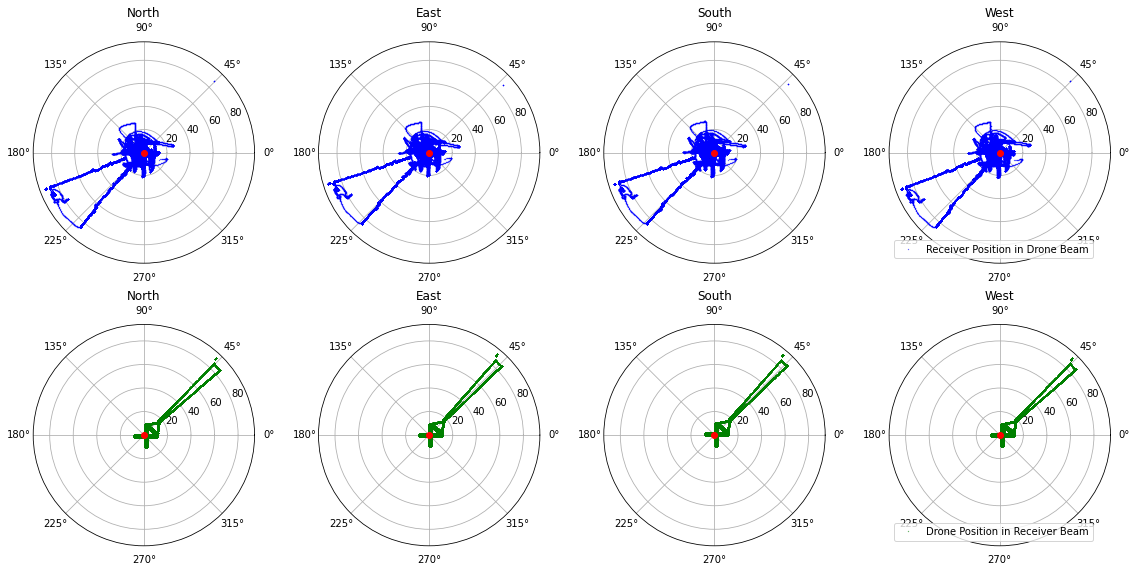

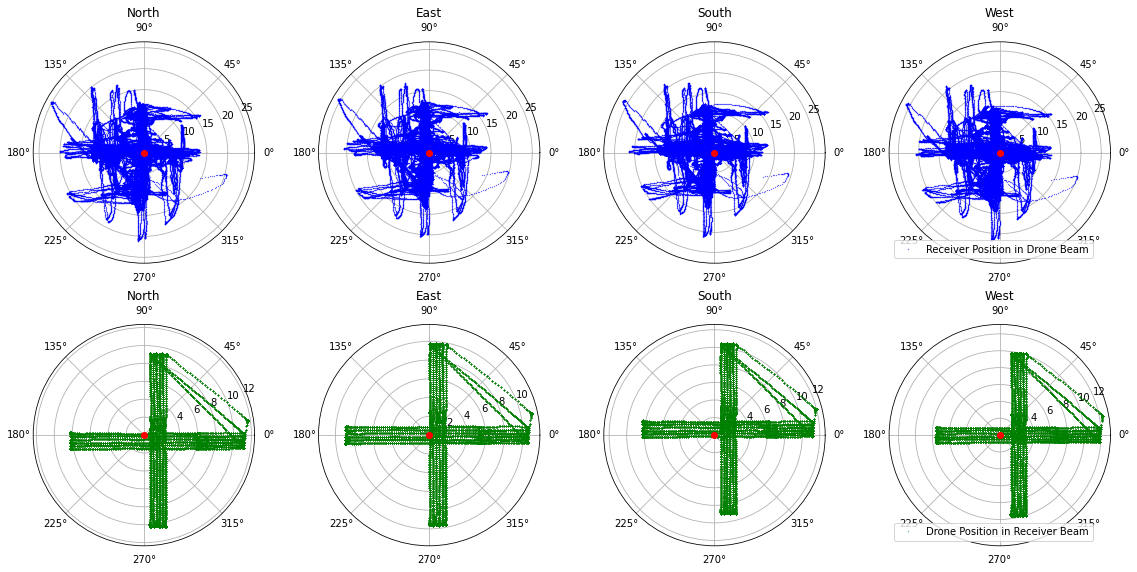

In [8]:
data.Plot_Polar_Lines_of_Sight()
data.Plot_Polar_Lines_of_Sight(t_bounds=[17000,115000],t_step=1)

In [9]:
## VECTORIZATION CODE for incorporating DRONE BEAM POINTING ##

## Rotation Matrix for Yaw,Pitch,Roll rotations about z,y,x axes:
def RotMat(ypr_arr):
    [a,b,c]=(np.pi/180.0)*ypr_arr
    RM=np.ndarray((3,3))
    RM[0,:]=[np.cos(a)*np.cos(b),np.cos(a)*np.sin(b)*np.sin(c)-np.sin(a)*np.cos(c),np.cos(a)*np.sin(b)*np.cos(c)+np.sin(a)*np.sin(c)]
    RM[1,:]=[np.sin(a)*np.cos(b),np.sin(a)*np.sin(b)*np.sin(c)+np.cos(a)*np.cos(c),np.sin(a)*np.sin(b)*np.cos(c)-np.cos(a)*np.sin(c)]
    RM[2,:]=[-1*np.sin(b),np.cos(b)*np.sin(c),np.cos(b)*np.cos(c)]
    return RM

## time index:
tind=data.t_index

## DRONE COORDINATE SYSTEM x,y,z=North,East,Down VARIABLES ##
UV_nose_north=np.array([1,0,0]) #unit vector for nose pointing north, no roll/pitch, prior to rotations
UV_trans_down=np.array([0,0,1]) #unit vector for transmitter pointing down prior to rotations
## drone roll, pitch, yaw angles:
ypr=np.ndarray((len(data.t_index),3))
ypr[:,0]=data.yaw
ypr[:,1]=data.pitch
ypr[:,2]=data.roll
## TRANSMITTER POINTING DIRECTION as fxn of time:
#trans_pointing_xyz_drone=np.array([RotMat(ypr[m,:])@UV_trans_down for m in range(len(tind))])

## LOCAL CARTESIAN COORDINATE SYSTEM x,y,z=East,North,Up VARIABLES ## (transform by [y,p,r]=[+90,0,+180] rot)
## drone position [t] in local cartesian relative to some point (e.g. BMX east dish):
xyz=data.coords_xyz_LC
## TRANSMITTER POINTING DIRECTION as fxn of time:
trans_pointing_xyz=np.array([RotMat(np.array([90.0,0.0,180.0]))@RotMat(ypr[m,:])@UV_trans_down for m in range(len(tind))])

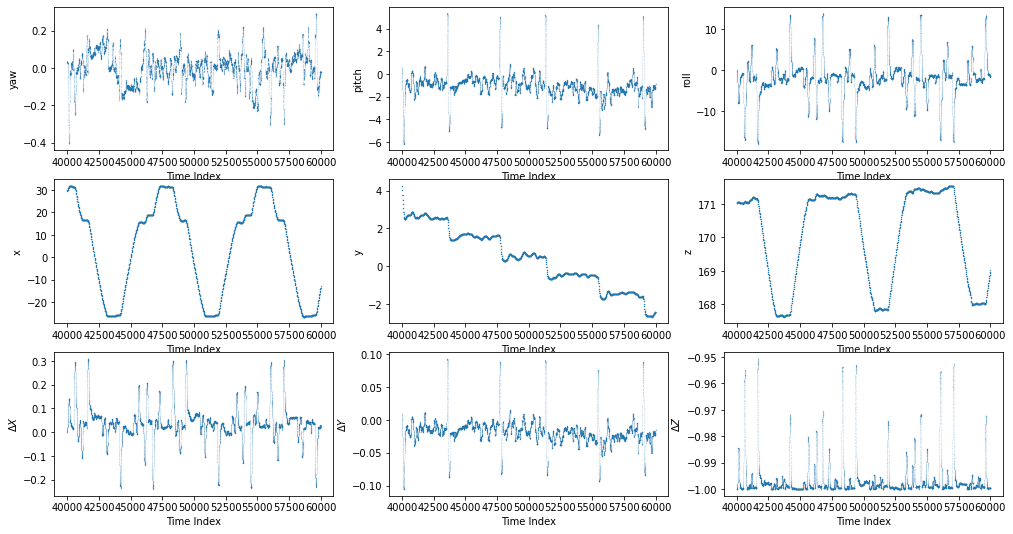

In [10]:
## Plotting Vector Pointing Coordinates
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9]]=subplots(nrows=3,ncols=3,figsize=(17,9))

pcols=[ypr[:,0],ypr[:,1],ypr[:,2],xyz[:,0],xyz[:,1],xyz[:,2],trans_pointing_xyz[:,0],trans_pointing_xyz[:,1],trans_pointing_xyz[:,2]]
ykeys=['yaw','pitch','roll','x','y','z','$\Delta X$','$\Delta Y$','$\Delta Z$']
for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]):
    ax.plot(tind[40000:60000],pcols[i][40000:60000],'.',markersize=0.1)
    ax.set_xlabel('Time Index')
    ax.set_ylabel(ykeys[i])

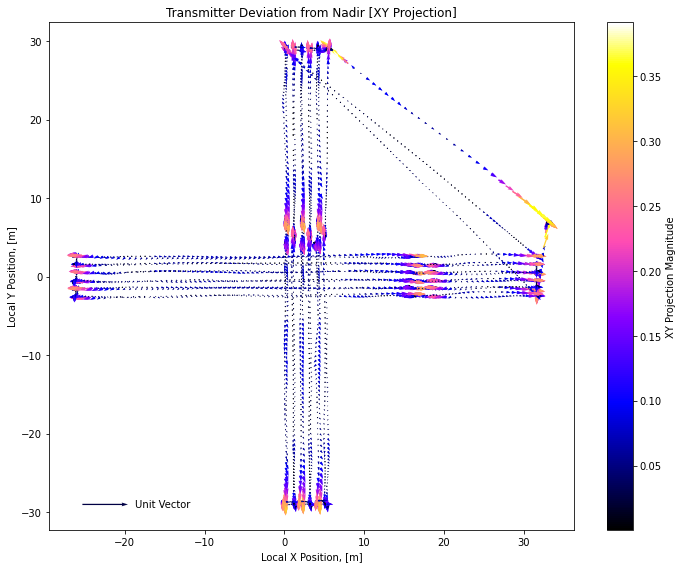

In [11]:
fig=figure(figsize=(10,8))
ax=fig.add_subplot(111)

[Qlb,Qub,Qstep]=[17000,115000,10]

M=np.abs(np.hypot(trans_pointing_xyz[Qlb:Qub:Qstep,0],trans_pointing_xyz[Qlb:Qub:Qstep,1]))

CNorm=colors.Normalize()
CNorm.autoscale(M)
CM=cm.gnuplot2
SM=cm.ScalarMappable(cmap=CM, norm=CNorm)
SM.set_array([])

#ax.plot(pcols[3][Qlb:Qub],pcols[4][Qlb:Qub],'.',markersize=.5)
q=ax.quiver(xyz[Qlb:Qub:Qstep,0],xyz[Qlb:Qub:Qstep,1],trans_pointing_xyz[Qlb:Qub:Qstep,0],trans_pointing_xyz[Qlb:Qub:Qstep,1],color=CM(CNorm(M)))
ax.quiverkey(q,X=0.15,Y=0.05,U=1,label='Unit Vector', labelpos='E')
fig.colorbar(SM,label='XY Projection Magnitude')


ax.set_xlabel('Local X Position, [m]')
ax.set_ylabel('Local Y Position, [m]')
ax.set_title('Transmitter Deviation from Nadir [XY Projection]')
tight_layout()
show()


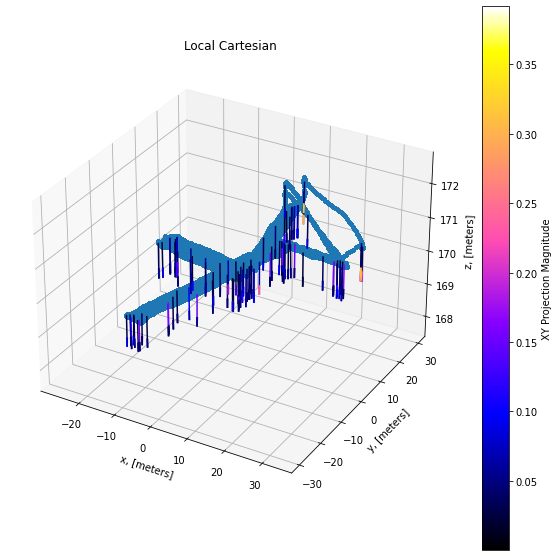

In [12]:
Qstep = 1000
fig=figure(figsize=(10,10))
ax=fig.add_subplot(1, 1, 1, projection='3d')
ax.set_title('Local Cartesian')
ax.set_xlabel('x, [meters]')
ax.set_ylabel('y, [meters]')
ax.set_zlabel('z, [meters]')
ax.plot(xyz[Qlb:Qub,0],xyz[Qlb:Qub,1],xyz[Qlb:Qub,2],'.')

q=ax.quiver(xyz[Qlb:Qub:Qstep,0],xyz[Qlb:Qub:Qstep,1],xyz[Qlb:Qub:Qstep,2],trans_pointing_xyz[Qlb:Qub:Qstep,0],trans_pointing_xyz[Qlb:Qub:Qstep,1],trans_pointing_xyz[Qlb:Qub:Qstep,2],color=CM(CNorm(M)))
#ax.quiverkey(q,X=0.15,Y=0.05,Z=1,U=1,label='Unit Vector', labelpos='E')
fig.colorbar(SM,label='XY Projection Magnitude')


In [13]:
## Calculating "FRIIS COEFFICIENT" Array, which is the proportionality between Receiver Beam and Pr/Pt ratio ##
    # For Autocorrelation data, this will have to be 4 dimensional: (Receiver, Polarization, Time, Freq)
    # This array can be multiplied elementwise by the power ratio (Pr/Pt) which will require CALIBRATED DATA.
    # The product of those is the Receiver Beam: D_r([theta,phi],receiver,polarization,freq)[time]
    # For each receiver, we will need to measure the position and pointing relative to our coordinate origin!
    
## Calculate Scalar Factor Array: (4*pi*R/lambda)**2
    # The radius R will be different for each receiver
    # The wavelength is a function of frequency
Wavelength_Array=(3.0e8/1.0e6)*np.outer(np.ones(len(time)),freq)**-1.0
R_Array=np.outer(data.coords_rpt[:,0],np.ones(len(freq)))
Sc_Factor=(4.0*np.pi*Wavelength_Array/R_Array)**2.0

## Calculate Efficiency Factor Array:  1/(e_t0*e_r0)
    # To actually calculate this, we will need efficiency measurements for each receiver polarization per freq.
    # We can include these later, if we collect these measurements, interpolate to frequencies in data
    # For now, it will all be ones (unity)!
Ecdt=1.0*np.ones(len(freq))        #conduction and dielectric (f)
Gammat=1.0*np.ones(len(freq))      #reflection coeff (f)
Eff_Trans=Ecdt*(1.0-(Gammat)**2.0) # e_t0 = total efficiency of transmitter (f)
Ecdr=1.0*np.ones(len(freq))
Gammar=1.0*np.ones(len(freq))
Eff_Rec=Ecdr*(1.0-(Gammar)**2.0)   # e_r0 = total efficiency of receiver (f)
Eff_Factor=np.outer(np.ones(len(time)),(Eff_Trans*Eff_Rec)**-1.0)

## Calculate PLF Factor: 1/mag(trans_pol_vec.rec_pol_vec)**2
## Define the pointing direction for the drone as a function of time, from rotating Nose direction:
drone_pol_pointing=np.array([RotMat(np.array([90.0,0.0,180.0]))@RotMat(ypr[m,:])@np.array([1,0,0]) for m in range(len(data.t_index))])
## Calculate the PLF (POLARIZATION LOSS FACTOR) for each receiver/polarization as fxn of time:
PLF_Factor=np.zeros((4,2,len(data.t_index)))
for j in range(4):
    for k in range(2):
        PLF_Factor[j,k,:]=np.array([np.dot(drone_pol_pointing,Array_Pols[j,k,:])**2.0])

## Calculate Transmitter Directivity Factor Array: 1/Dt(theta_t,phi_t)
    # Depends on receiver position as seen by drone transmitter as a function of time


## Initialize "FRIIS_COEFF_ARRAY" -- the output data product, which has same dims as data:
FRIIS_COEFF_ARRAY=Sc_Factor*Eff_Factor


TypeError: object of type 'module' has no len()

In [14]:
## ADDITIONAL VECTORIZATION CODING/PROOFS ##
    # CHANGES to drone class following this work:
    # 1. Want to initialize with additional receiver/array variables in dimensioned arrays:
            ##############################################################################################
            # I  Variable      # Dimension # description
            ##############################################################################################
            # A. Keys          # n dishes  # (string with name or channel index?)
            # B. Coordinates   # n by 3vec # (Vector position in local cartesian (E,N,U) relative origin)
            # C. Pointings     # n by 3vec # (Unit Vector in local cartesian (E,N,U))
            # D. Polarizations # n by 3vec # (Unit Vector in local cartesian (E,N,U))
            ##############################################################################################
    # 2. Want to calculate drone coordinates on per-dish basis, for xyz and rpt from origin based arrays

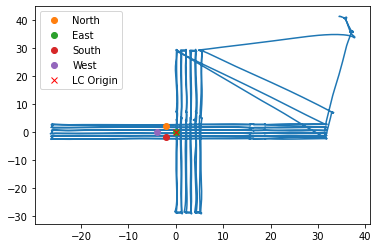

In [15]:
## RECEIVER INFORMATION is needed to initialize the geometric environments: ##
## Must include some 'key' strings for labelling/identifying receivers:
Array_Keys=['North','East','South','West']
## Must Specify Coordinates and Pointings of receivers in Local Cartesian in an array of shape: n_receivers x 3 ##
Array_Coords=np.array([[-2.0,2.0,0.1],\
                       [0.0,0.0,0.1],\
                       [-2.0,-2.0,0.1],\
                       [-4.0,0.0,0.1]])
## If pointings are defined by vectors in Local Coordinates (E,N,U) use:
Array_Pointings=np.array([[0,0,1], # +Z (up) in LC \
                          [0,0,1],\
                          [0,0,1],\
                          [0,0,1]])
## If pointings are defined by angles from zenith, use:
Array_Pointings=np.array([RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),  # e.g. 1 deg of yaw and roll \
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0]),\
                          RotMat(np.array([0.0,0.0,0.0]))@np.array([0.0,0.0,1.0])])
## Define Array Polarizations (2 per dish) in Local Cartesian E,N,U:
Array_Pols=np.array([[[1,0,0],[0,1,0]], # E,N \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]], \
                     [[1,0,0],[0,1,0]]])

plot(data.coords_xyz_LC[:,0],data.coords_xyz_LC[:,1])
for i in range(len(Array_Keys)):
    plot(Array_Coords[i,0],Array_Coords[i,1],'o',label=Array_Keys[i])
plot(0,0,'rx',label='LC Origin')
legend()

In [16]:
## RPT Coordinates for drone per dish after TRANSLATION of origin to dish_coords and ROTATION by dish_pointing
## Therefore this should be (R,theta_r,phi_r,theta_t,phi_t) for dish 0 as function of time!
rpt_r_per_dish=np.zeros((len(Array_Coords),data.coords_xyz_LC.shape[0],data.coords_xyz_LC.shape[1]))
rpt_t_per_dish=np.zeros((len(Array_Coords),data.coords_xyz_LC.shape[0],data.coords_xyz_LC.shape[1]))
for i in range(len(Array_Keys)):
    ## Receiver RPT after TRANS and ROT: (from receiver N to Drone in Receiver Caretsian "RC" coords)
    drone_xyz_RC=data.coords_xyz_LC-Array_Coords[i] # translate LC to receiver i position
    ## Rotate coord system by dish pointing with rotation matrix (constant in t):
    rec_pointing_rot=RotMat(np.array([xyz_to_rpt(Array_Pointings[i])[2],0.0,xyz_to_rpt(Array_Pointings[i])[1]]))
    rpt_r_per_dish[i,:,:]=np.array([xyz_to_rpt(rec_pointing_rot@drone_xyz_RC[k]) for k in range(len(data.coords_xyz_LC))])
    ## Transmitter RPT after TRANS and ROT: (from Drone to receiver N in Drone coords)
    rec_xyz_LC=-1.0*(data.coords_xyz_LC)+Array_Coords[i] # in LC relative to drone, without rotation (yet)
    ## Rotate coord system by drone pointing with rotation matrix (varies with yaw,pitch,roll as fxns of t):
    ypr=np.ndarray((len(data.t_index),3))
    ypr[:,0]=data.yaw
    ypr[:,1]=data.pitch
    ypr[:,2]=data.roll
    rpt_t_per_dish[i,:,:]=np.array([xyz_to_rpt(RotMat(ypr[m,:])@(RotMat(np.array([90.0,0.0,180.0]))@rec_xyz_LC[m])) for m in range(len(data.coords_xyz_LC))])

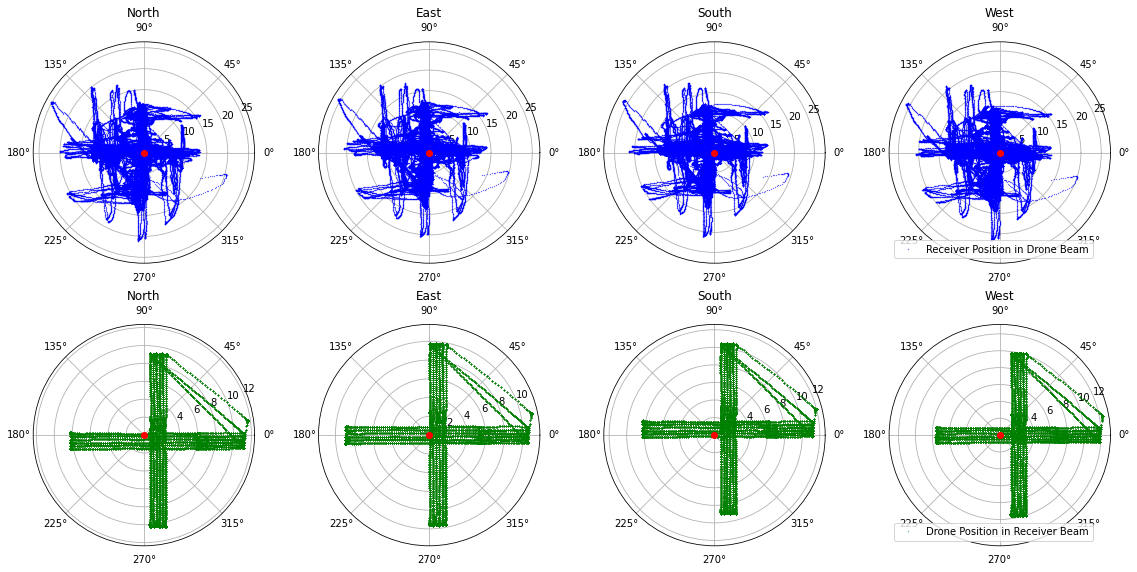

In [17]:
fig1,axes=subplots(nrows=2,ncols=4,figsize=(16,8),subplot_kw=dict(projection="polar"))
for i,ax in enumerate(axes[0]):
    ax.set_title(Array_Keys[i])
    ax.plot(rpt_t_per_dish[i,17000:115000,1],180.0/np.pi*rpt_t_per_dish[i,17000:115000,2],'.b',markersize=0.5,label='Receiver Position in Drone Beam')
    ax.plot(0,0,'ro')
ax.legend(loc=3)
for j,ax in enumerate(axes[1]):
    ax.set_title(Array_Keys[j])
    ax.plot(rpt_r_per_dish[j,17000:115000,1],180.0/np.pi*rpt_r_per_dish[j,17000:115000,2],'.g',markersize=0.5,label='Drone Position in Receiver Beam')
    ax.plot(0,0,'ro')
ax.legend(loc=3)
tight_layout()

In [18]:
## Define the pointing direction for the drone as a function of time, from rotating Nose direction:
drone_pol_pointing=np.array([RotMat(np.array([90.0,0.0,180.0]))@RotMat(ypr[m,:])@np.array([1,0,0]) for m in range(len(data.t_index))])

## Calculate the PLF (POLARIZATION LOSS FACTOR) for each receiver/polarization as fxn of time:
PLF_Factor=np.zeros((4,2,len(data.t_index)))
for j in range(4):
    for k in range(2):
        PLF_Factor[j,k,:]=np.array([np.dot(drone_pol_pointing,Array_Pols[j,k,:])**2.0])

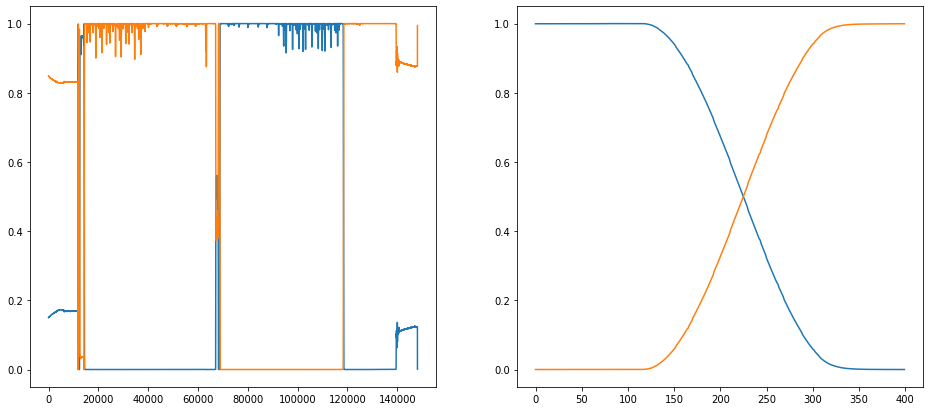

In [19]:
fig1,[ax1,ax2]=subplots(nrows=1,ncols=2,figsize=(16,7))
## Close to 1 when pointing NORTH, Close to 0 when pointing WEST as expected
ax1.plot(PLF_Factor[0,0,:])
ax1.plot(PLF_Factor[0,1,:])
## Zoom in on a closer section where they cross to see if it seems legitimate... YES it is smoothly varying
ax2.plot(PLF_Factor[0,0,118200:118600])
ax2.plot(PLF_Factor[0,1,118200:118600])

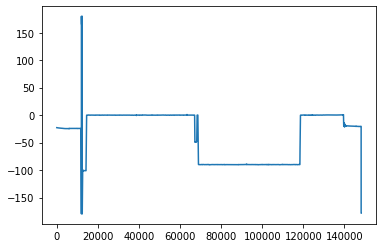

In [20]:
plot(ypr[:,0])

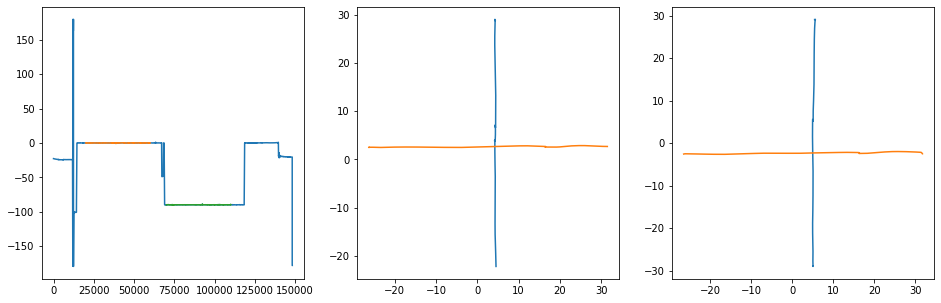

In [21]:
## Need to examine theta,phi for receiver and transmitter for geometry purposes
    # Clearly the receiver theta and phi do not rotate, so theta=0 is east, phi is measured from zenith
    # Transmitter theta and phi should rotate as drone yaws/pitches/rolls

fig1,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,5))
ax1.plot(data.t_index[:],data.yaw[:])
## Transmitter is polarized NORTH (yaw=0deg) from 20000:60000 in time index
    # From time 20000:38000 drone moves NS cross throws
    # From time 42000:60000 drone moves EW cross throws
ax1.plot(data.t_index[20000:60000],data.yaw[20000:60000]) #Pure NS pol
ax2.plot(data.coords_xyz_LC[19200:22500,0],data.coords_xyz_LC[19200:22500,1]) #Pure NS pol, pure NS Movement
ax2.plot(data.coords_xyz_LC[40500:43300,0],data.coords_xyz_LC[40500:43300,1]) #Pure NS pol, pure EW Movement
## Transmitter is polarized WEST (yaw=-90deg=270deg) from 70000:110000 in time index
    # From time 70000:88000 drone moves NS cross throws
    # From time 94000:110000 drone moves EW cross throws
ax1.plot(data.t_index[70000:110000],data.yaw[70000:110000]) #Pure EW pol
ax3.plot(data.coords_xyz_LC[69000:72000,0],data.coords_xyz_LC[69000:72000,1]) #Pure EW pol, pure NS Movement
ax3.plot(data.coords_xyz_LC[94000:97000,0],data.coords_xyz_LC[94000:97000,1]) #Pure EW pol, pure EW Movement

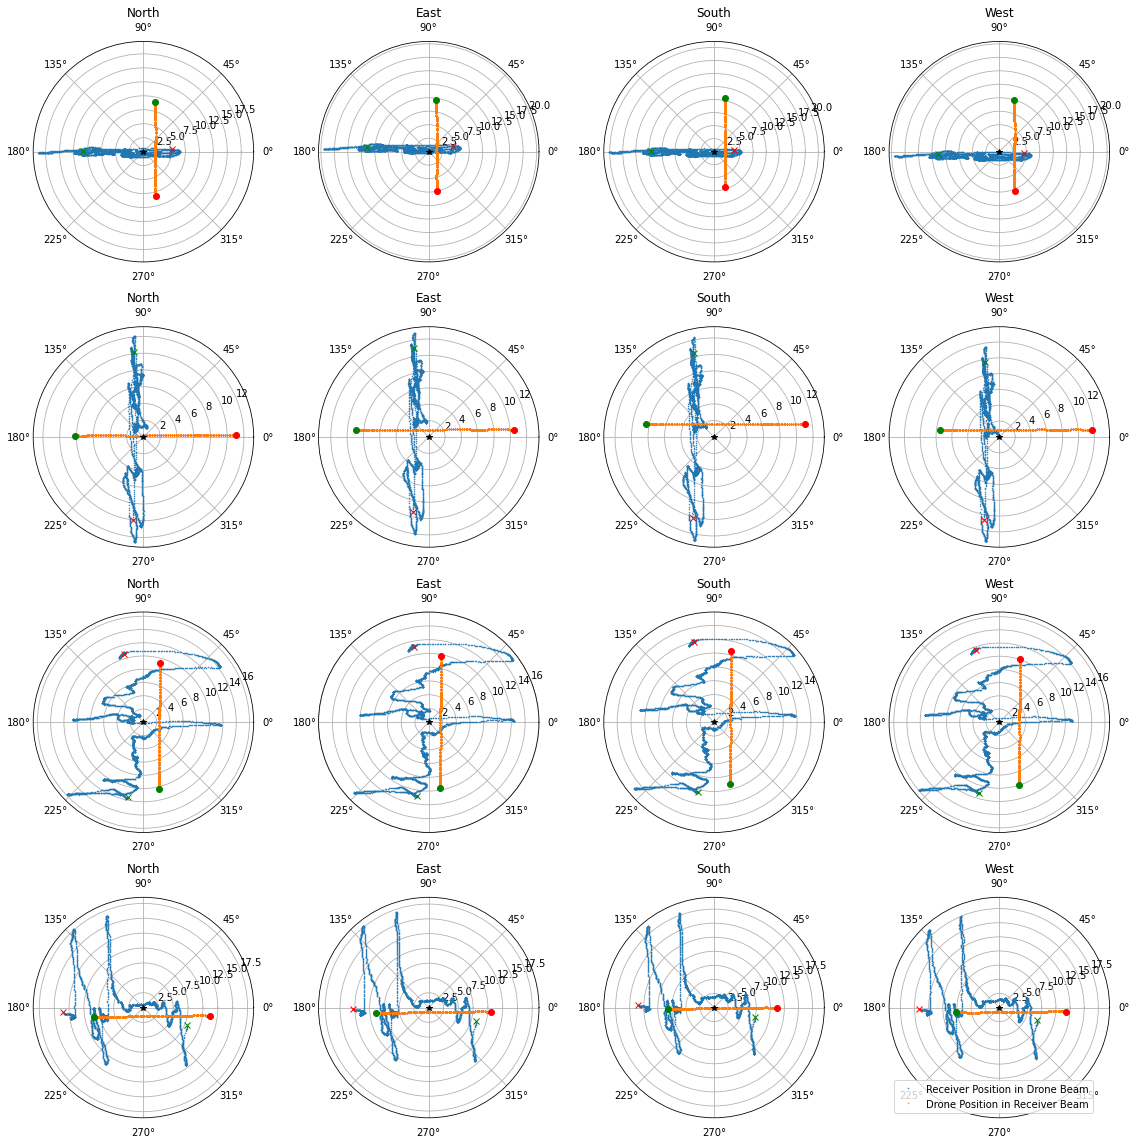

In [22]:
BNDS=[[19200,22500],[40500,43300],[69000,72000],[94000,97000]]
fig1,axes=subplots(nrows=4,ncols=4,figsize=(16,16),subplot_kw=dict(projection="polar"))
for j,inds in enumerate(BNDS):
    PLB,PUB=inds
    for i,ax in enumerate(axes[j,:]):
        ax.set_title(Array_Keys[i])
        ax.plot(rpt_t_per_dish[i,PLB:PUB,1],180.0/np.pi*rpt_t_per_dish[i,PLB:PUB,2],'.',markersize=1.0,label='Receiver Position in Drone Beam')
        ax.plot(rpt_t_per_dish[i,PLB,1],180.0/np.pi*rpt_t_per_dish[i,PLB,2],'rx')
        ax.plot(rpt_t_per_dish[i,PUB,1],180.0/np.pi*rpt_t_per_dish[i,PUB,2],'gx')
        ax.plot(rpt_r_per_dish[i,PLB:PUB,1],180.0/np.pi*rpt_r_per_dish[i,PLB:PUB,2],'.',markersize=1.0,label='Drone Position in Receiver Beam')
        ax.plot(rpt_r_per_dish[i,PLB,1],180.0/np.pi*rpt_r_per_dish[i,PLB,2],'ro')
        ax.plot(rpt_r_per_dish[i,PUB,1],180.0/np.pi*rpt_r_per_dish[i,PUB,2],'go')
        ax.plot(0,0,'k*')
ax.legend(loc=3)
tight_layout()

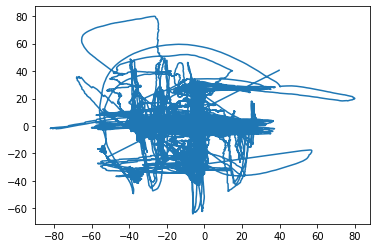

In [23]:
## Do the interim steps produce what we expect for vector products?
## This is an array of receiver position relative to drone after changing coords and rotating through YPR:
    # Without the YPR rotation, x->y,y->x,z->-z when coord system changes, as predicted.
ttt=np.array([(RotMat(ypr[m,:])@(RotMat(np.array([90.0,0.0,180.0]))@rec_xyz_LC[m])) for m in range(len(data.coords_xyz_LC))])
## The coordinate map shows the flight pattern, exaggerated by the yaw, pitch, and roll:
plot(ttt[:,0],ttt[:,1])

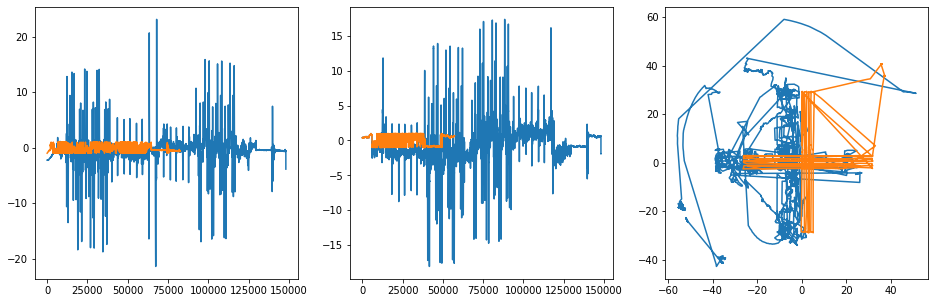

In [24]:
fig1,[ax1,ax2,ax3]=subplots(nrows=1,ncols=3,figsize=(16,5))
lowp=np.intersect1d(np.where(ypr[:,1]>=-1.0),np.where(ypr[:,1]<=1.0))
lowr=np.intersect1d(np.where(ypr[:,2]>=-1.0),np.where(ypr[:,2]<=1.0))
qzz=np.intersect1d(lowp,lowr).tolist()
ax1.plot(ypr[:,1])
ax1.plot(ypr[:,1][lowp])
ax2.plot(ypr[:,2])
ax2.plot(ypr[:,2][lowr])
ax3.plot(ttt[:,0][qzz],ttt[:,1][qzz])
ax3.plot(xyz[:,0][qzz],xyz[:,1][qzz])

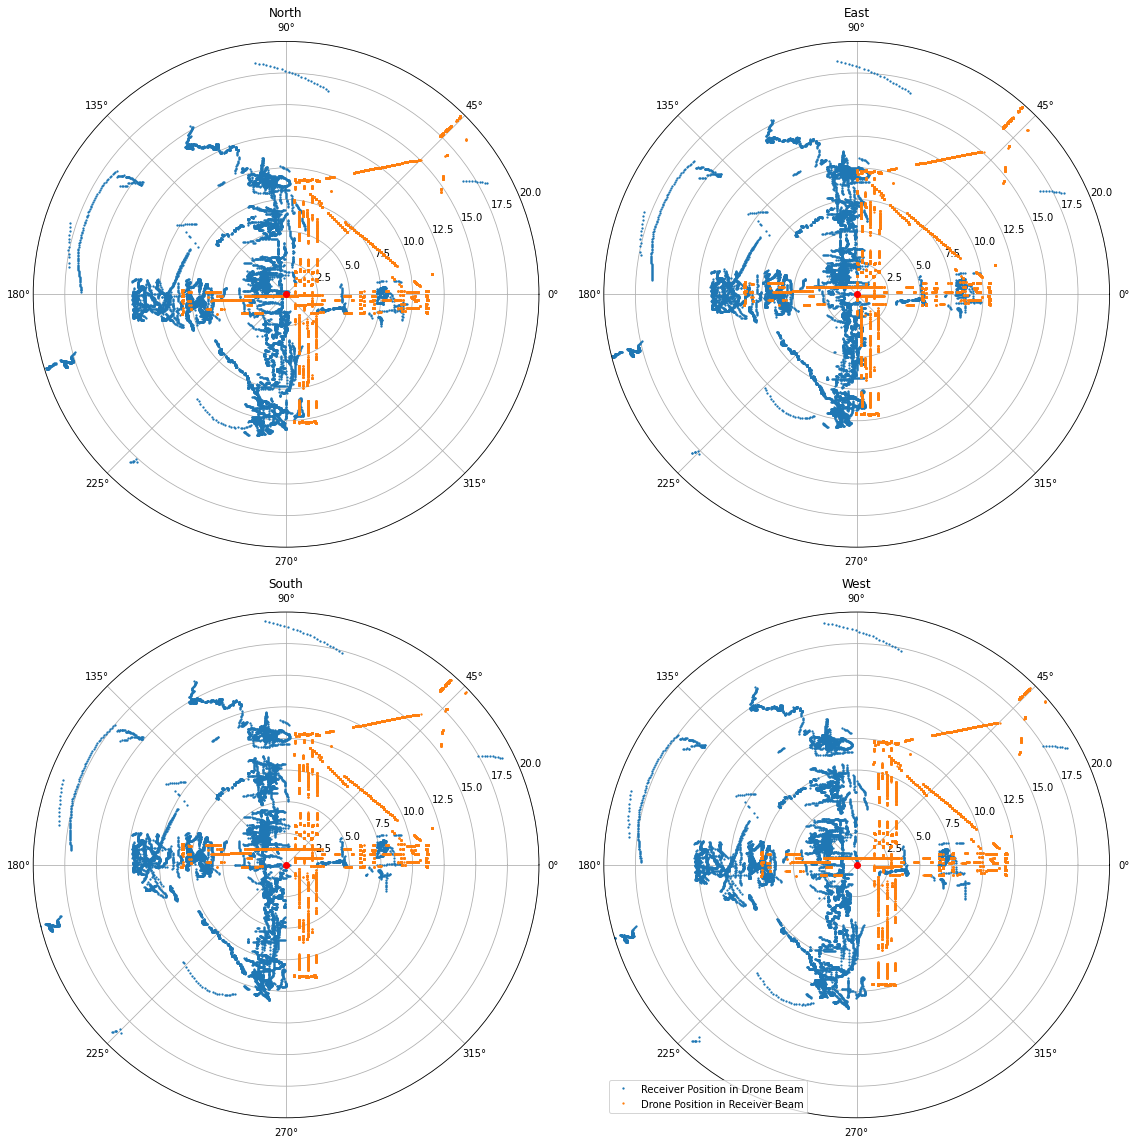

In [25]:
## When the drone isn't swaying, are the receiver positions similar? YES
    # This looks to be correct
fig1,[[ax1,ax2],[ax3,ax4]]=subplots(nrows=2,ncols=2,figsize=(16,16),subplot_kw=dict(projection="polar"))
for i,ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.set_title(Array_Keys[i])
    #ax.plot(rpt_t_per_dish[i,:,1],180.0/np.pi*rpt_t_per_dish[i,:,2],'.',markersize=2.5,label='Receiver Position in Drone Beam')
    #ax.plot(rpt_r_per_dish[i,:,1],180.0/np.pi*rpt_r_per_dish[i,:,2],'.',markersize=2.5,label='Drone Position in Receiver Beam')
    ax.plot(rpt_t_per_dish[i,:,1][qzz],180.0/np.pi*rpt_t_per_dish[i,:,2][qzz],'.',markersize=2.5,label='Receiver Position in Drone Beam')
    ax.plot(rpt_r_per_dish[i,:,1][qzz],180.0/np.pi*rpt_r_per_dish[i,:,2][qzz],'.',markersize=2.5,label='Drone Position in Receiver Beam')
    ax.plot(0,0,'ro')
    ax.set_rlim(0,20)
ax.legend(loc=3)
tight_layout()

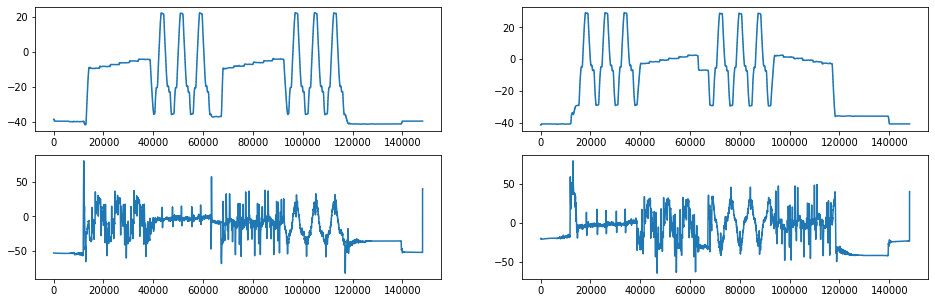

In [26]:
fig1,[[ax1,ax2],[ax3,ax4]]=subplots(nrows=2,ncols=2,figsize=(16,5))
ax1.plot(rec_xyz_LC[:,0]) # NS coordinates in LC
ax2.plot(rec_xyz_LC[:,1]) # EW coordinates in LC
ax3.plot(ttt[:,0]) # "NS" motion in Drone Frame (*N rotated by yaw*)
ax4.plot(ttt[:,1]) # "EW" motion in Drone Frame (*E rotated by yaw*)

# Before 65000, NS drone polarization --> NS movement in LC produces "NS" movement in Drone Frame
# AFTER 65000,  EW drone polarization --> NS movement in LC produces "EW" movement in Drone Frame

In [27]:
## VECTORIZATION Definition Testing:
## Start with a point in LC = [East,North,Up] = [x,y,z]
LCpos=np.array([0.0,10.0,0.0]) # North
## Convert this to [North,East,Down]=[x,y,z]
DCpos=RotMat(np.array([90.0,0.0,180.0]))@LCpos
## Which direction does a +yaw rotation work? e.g yaw of +90deg
print(np.array(RotMat(np.array([0.0,0.0,0.0]))@DCpos))
print(np.array(RotMat(np.array([30.0,0.0,0.0]))@DCpos))
print(np.array(RotMat(np.array([-30.0,0.0,0.0]))@DCpos))

[ 1.0000000e+01 -6.1232340e-16  1.2246468e-15]
[8.66025404e+00 5.00000000e+00 1.22464680e-15]
[ 8.66025404e+00 -5.00000000e+00  1.22464680e-15]


In [28]:
np.array(xyz_to_rpt(RotMat(np.array([-90.0,0.0,0.0]))@(RotMat(np.array([90.0,0.0,180.0]))@np.array([30,30,-1000]))))

array([1.00089960e+03, 5.49778714e+00, 4.24009785e-02])

In [29]:
xyz_to_rpt(RotMat(np.array([-90.0,0.0,0.0]))@(RotMat(np.array([90.0,0.0,180.0]))@np.array([1,1,-1000])))

[1000.0009999995, 5.497787143782199, 0.0014142126195679618]

In [30]:
print(10*np.cos(np.pi/3),10*np.sin(np.pi/3))

5.000000000000001 8.660254037844386


In [31]:
rpt_r_per_dish[0,94000:97000]
rpt_t_per_dish[0,94000:97000]

array([[1.74656797e+02, 3.20312689e+00, 2.35819971e-01],
       [1.74656797e+02, 3.20685948e+00, 2.34899384e-01],
       [1.74656797e+02, 3.20863035e+00, 2.34363909e-01],
       ...,
       [1.69764912e+02, 5.85986847e+00, 1.40201776e-01],
       [1.69769474e+02, 5.87650189e+00, 1.39493427e-01],
       [1.69769474e+02, 5.88902026e+00, 1.38942975e-01]])

In [32]:
ttt=np.array([(RotMat(ypr[m,:])@(RotMat(np.array([90.0,0.0,180.0]))@rec_xyz_LC[m])) for m in range(len(data.coords_xyz_LC))])
zzz=np.array([(RotMat(np.array([90.0,0.0,180.0]))@rec_xyz_LC[m]) for m in range(len(data.coords_xyz_LC))])


[-90.02463983  -1.39633681  -4.48316398] [-0.23088189 -1.31908003 -1.52791989]
[ 0.06106976 -0.80015279 -0.62793634] [-90.04091208  -1.33899804   0.39980584]


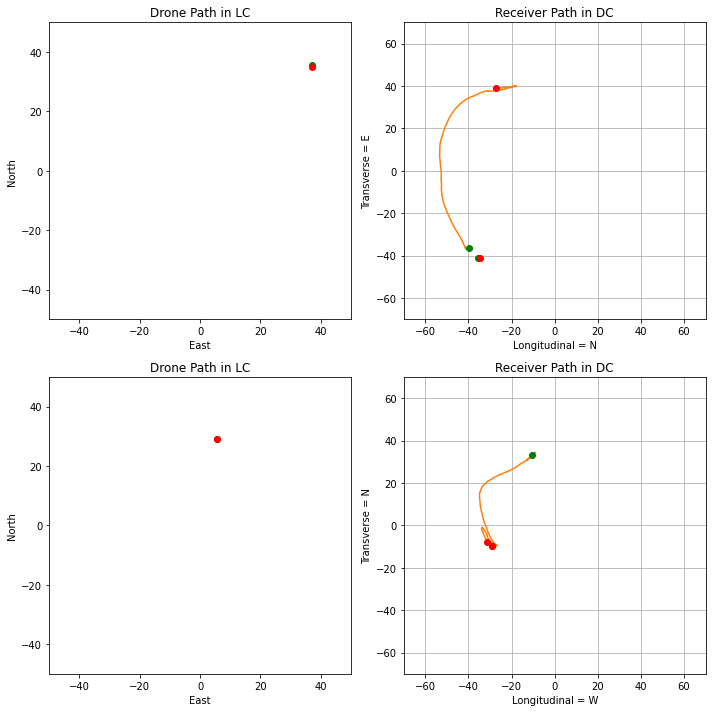

In [33]:
## This was for understanding how a change in yaw makes the receiver move in the drone reference frame
    # The answer is, the coordinate axes rotate in response to a change in yaw:
fig1,[[ax1,ax2],[ax3,ax4]]=subplots(nrows=2,ncols=2,figsize=(10,10))
zlb,zub=BNDS[0]

zlb,zub=[118200,118600]

ax1.set_title('Drone Path in LC')
ax1.plot(xyz[zlb:zub,0],xyz[zlb:zub,1])
ax1.plot(xyz[zub,0],xyz[zub,1],'go')
ax1.plot(xyz[zlb,0],xyz[zlb,1],'ro')
ax1.set_xlim(-50,50)
ax1.set_ylim(-50,50)
ax1.set_xlabel('East')
ax1.set_ylabel('North')

print(ypr[zlb,:],ypr[zub,:])
ax2.set_title('Receiver Path in DC')
ax2.plot(zzz[zlb:zub,0],zzz[zlb:zub,1])
ax2.plot(ttt[zlb:zub,0],ttt[zlb:zub,1])
ax2.plot(zzz[zub,0],zzz[zub,1],'go')
ax2.plot(zzz[zlb,0],zzz[zlb,1],'ro')
ax2.plot(ttt[zub,0],ttt[zub,1],'go')
ax2.plot(ttt[zlb,0],ttt[zlb,1],'ro')
ax2.set_xlim(-70,70)
ax2.set_ylim(-70,70)
ax2.set_xlabel('Longitudinal = N')
ax2.set_ylabel('Transverse = E')
ax2.grid()

zlb,zub=BNDS[2]
zlb,zub=[118200,118600]
zlb,zub=[68500,69000]
ax1=ax3
ax2=ax4
ax1.set_title('Drone Path in LC')
ax1.plot(xyz[zlb:zub,0],xyz[zlb:zub,1])
ax1.plot(xyz[zub,0],xyz[zub,1],'go')
ax1.plot(xyz[zlb,0],xyz[zlb,1],'ro')
ax1.set_xlim(-50,50)
ax1.set_ylim(-50,50)
ax1.set_xlabel('East')
ax1.set_ylabel('North')

print(ypr[zlb,:],ypr[zub,:])
ax2.set_title('Receiver Path in DC')
ax2.plot(zzz[zlb:zub,0],zzz[zlb:zub,1])
ax2.plot(ttt[zlb:zub,0],ttt[zlb:zub,1])
ax2.plot(zzz[zub,0],zzz[zub,1],'go')
ax2.plot(zzz[zlb,0],zzz[zlb,1],'ro')
ax2.plot(ttt[zub,0],ttt[zub,1],'go')
ax2.plot(ttt[zlb,0],ttt[zlb,1],'ro')
ax2.set_xlim(-70,70)
ax2.set_ylim(-70,70)
ax2.set_xlabel('Longitudinal = W')
ax2.set_ylabel('Transverse = N')
ax2.grid()


tight_layout()



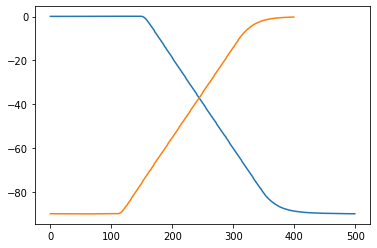

In [34]:
plot(ypr[68500:69000,0])
plot(ypr[118200:118600,0])

(0.0, 30.0)

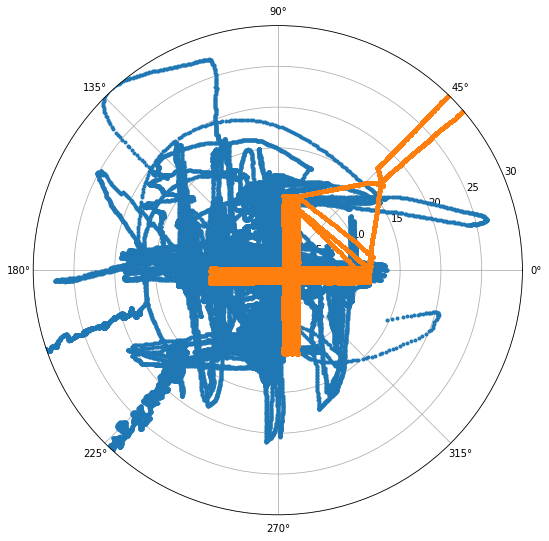

In [35]:
## This is replotting the above plots of drone in receiver beam and receiver in drone beam:
fig=figure(figsize=(9,9))
ax1=fig.add_subplot(111,projection='polar')
plot(rpt_t_per_dish[0,:,1],rpt_t_per_dish[0,:,2]*180.0/np.pi,'.')
plot(rpt_r_per_dish[0,:,1],rpt_r_per_dish[0,:,2]*180.0/np.pi,'.')
ax1.set_rlim(0,30)

In [38]:
data.t_arr_datetime[0]

datetime.datetime(2020, 3, 11, 18, 57, 44, 187000, tzinfo=<UTC>)